In [2]:
import segmentation_models_pytorch as smp
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets

import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
DATA_DIR = "./deepglobe-land-cover-classification-dataset/train"
COLOR_CODES = "./deepglobe-land-cover-classification-dataset/class_dict.csv"

# Define the U-Net model
def get_unet_model(num_classes):
    model = smp.Unet(
        encoder_name="resnet34",        # You can use different encoders like resnet18, resnet50, etc.
        encoder_weights="imagenet",     # You can also initialize the encoder with weights pretrained on ImageNet
        in_channels=3,                  # Number of input channels (RGB)
        classes=num_classes,            # Number of output classes
    )
    return model

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet mean and std
])

df = pd.read_csv(COLOR_CODES)
label_map = {}

for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
    
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [23]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg') and not filename.startswith("._")])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png') and not filename.startswith("._")])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return {"image": image, "mask": mask}
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [30]:

big_dataset = Segmentation_Dataset(DATA_DIR, label_map, transform)
[train_dataset, val_dataset, test_dataset] = torch.utils.data.random_split(big_dataset,[0.75,0.15,0.1], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

train_batch = next(iter(train_dataloader))

print(train_batch['image'].shape)
print(train_batch['mask'].shape)



torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


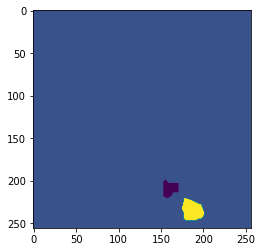

In [25]:
plt.imshow(np.transpose(train_batch['mask'][0], (1, 2, 0)))

In [32]:
num_classes = 7  # Adjust based on the number of classes in DeepGlobe dataset
model = get_unet_model(num_classes)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for image, mask in train_dataloader:
        optimizer.zero_grad()
        print(type(image))
        outputs = model(image)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for image, mask in valid_dataloader:
            outputs = model(image)
            val_loss += criterion(outputs, mask).item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss/len(valid_dataloader):.4f}')

# Save the trained model
torch.save(model.state_dict(), 'unet_deepglobe.pth')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'str'>


AttributeError: 'str' object has no attribute 'shape'